In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
N = 164689383

In [3]:
df = pd.read_csv("covid19bd.csv", header = 0) # dataset
df.head()

,Date,Tested,Confirmed,Isolation,Recovered,Death
0,1/5/2020,5573,571,175,14,2
1,2/5/2020,5827,552,168,3,5
2,3/5/2020,5368,665,65,886,2
3,4/5/2020,6260,688,90,147,5
4,5/5/2020,5711,786,128,193,1


In [4]:
available = len(df.index) 
print("Available", available, "days")

Available 58 days


In [5]:
start_date = df['Date'].iloc[0]
infected = df['Confirmed'].values.tolist()
tested = df['Tested'].values.tolist()
recovered = df['Recovered'].values.tolist()
deaths = df['Death'].values.tolist()
isolation = df['Isolation'].values.tolist()

In [6]:
t_max = available + 7

date = np.array('2020-05-01', dtype=np.datetime64) 
dates = date + np.arange(t_max)
# print(np.arange(t_max))
str_dates = []
for i in dates:
    str_dates.append(str(i))
    
# str_dates    

In [7]:
def seird_model_sd(init_vals, params, t, rho):

    DATE_0, S_0, E_0, I_0, Is_0, R_0, D_0 = init_vals
    DATE, S, E, I, Is, R, D = [DATE_0], [S_0], [E_0],[I_0], [Is_0], [R_0], [D_0]
    alpha, beta, gamma, delta, miu = params
    
    ##### Create next t days ######
    date = np.array(DATE, dtype=np.datetime64)
    dates = date + np.arange(len(t))
    str_dates = []
    for i in dates:
        str_dates.append(str(i))
        
    ##### End creating t days #####
    for tic in t[1:]:

        DATE.append(str_dates[tic])

        next_S = abs(S[-1] - ( rho*beta * (S[-1] / N) * I[-1] ))   # Susceptible
        next_E = abs(E[-1] + ( rho*beta * (S[-1] / N) * I[-1] ) - ( alpha * E[-1] ) - (miu * E[-1])) # Exposed
        next_I = abs(I[-1] + ( miu * E[-1] ) - ( gamma * I[-1] ) - ( delta * I[-1] )) # Infected
        next_Is = abs(Is[-1] + ( alpha * E[-1] )) #Isolation
        next_R = abs (R[-1] + ( gamma * I[-1] )) # Recovered
        next_D = abs (D[-1] + ( delta * I[-1] )) # Deaths
        
        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        Is.append(next_Is)
        R.append(next_R)
        D.append(next_D)


    return np.stack([DATE, S, E, I, Is, R, D]).T

In [8]:
train_min = 1
train_max = available + 1

inf_train = []
rec_train = []
death_train = []
iso_train = []

for i in range(train_min+1, train_max):
    j = i - 2
    inf_train.append(infected[j:i])
    rec_train.append(recovered[j:i])
    death_train.append(deaths[j:i])
    iso_train.append(isolation[j:i])

In [9]:
t2 = np.arange(0, 3, 1)
print(t2)

[0 1 2]


In [10]:
rho = 1

In [187]:
last7_vals = []
last7_params = []

# vals=[]
# param = []

t_incub = 7  # Assumption 7 days

for sample in range(len(inf_train)):

    i_0 = inf_train[sample][0]
    i_1 = inf_train[sample][1]
    i_diff = i_1 - i_0


    r_0 = rec_train[sample][0]
    r_1 = rec_train[sample][1]
    r_diff = r_1 - r_0


    d_0 = death_train[sample][0]
    d_1 = death_train[sample][1]
    d_diff = d_1 - d_0
    
    is_0 = iso_train[sample][0]
    is_1 = iso_train[sample][1]
    is_diff = is_1 - is_0


#     if (sample == 0):

    e_0 = (tested[sample] + isolation[sample])
    e_1 = (tested[sample+1] + isolation[sample+1])
    e_diff = e_1 - e_0
        
    s_0 = N - e_0 - i_0 - is_0 - r_0 - d_0
          

    alpha = abs((is_diff) / e_0)  # alpha
    beta = abs(( ( ( e_diff + i_diff + r_diff + d_diff+ is_diff) * N ) / ( s_0 * i_0 ) )) # beta
    gamma = abs(r_diff / i_0 ) # gamma
    delta = abs(d_diff / i_0)  # delta
    miu = abs((i_diff + r_diff + d_diff)/e_0) #miu

    init_vals = str_dates[sample], s_0, e_0, i_0, is_0, r_0, d_0
    params = alpha, beta, gamma, delta, miu
    pred = seird_model_sd(init_vals, params, t2, rho)
    
    # Date: 0, S:1, E:2, I:3, Is:4, R:5, D:6
    

    
    # Store Last seven cases for predecting future
    if ((len( inf_train )  - sample ) <= 11 and (len( inf_train )  - sample ) > 0 ):
        print(str_dates[sample])
        last7_vals.append(init_vals)
        last7_params.append(params)

2020-06-16
2020-06-17
2020-06-18
2020-06-19
2020-06-20
2020-06-21
2020-06-22
2020-06-23
2020-06-24
2020-06-25
2020-06-26


In [188]:
t = np.arange(0,10,1)
final=[]

In [189]:
val=[]
results = seird_model_sd(last7_vals[0], last7_params[0], t, rho)
print("Predictions using", last7_vals[0][0], "parameters\n")
print("-----------------------------------------------------------------")
print("Date", "\t\tInfected", "\tRecovered", "\tDeaths", "\t Isolation")
print("-----------------------------------------------------------------")
print(results[0][0], "\t", int(float(results[0][3])), "\t\t", int(float(results[0][5])), 
              "\t\t", int(float(results[0][6])), "\t ", int(float(results[0][4])),"\t\t")
print("------------------------------------------------------------------\n\n") 
val.append(results[0][0])
val.append(int(float(results[0][1])))
val.append(int(float(results[0][2])))
val.append(int(float(results[0][3])))
val.append(int(float(results[0][4])))
val.append(int(float(results[0][5])))
val.append(int(float(results[0][6])))

final.append(val)

Predictions using 2020-06-16 parameters

-----------------------------------------------------------------
Date 		Infected 	Recovered 	Deaths 	 Isolation
-----------------------------------------------------------------
2020-06-16 	 3862 		 2237 		 53 	  635 		
------------------------------------------------------------------




In [190]:
t1 = np.arange(0,2,1)

In [191]:
for day in t:
    val=[]
    results = seird_model_sd(final[day], last7_params[day], t1, rho)
    print("Predictions using", final[day][0], "parameters\n")
    print("-----------------------------------------------------------------")
    print("Date", "\t\tInfected", "\tRecovered", "\tDeaths", "\t Isolation")
    print("-----------------------------------------------------------------")
    print(results[1][0], "\t", int(float(results[1][3])), "\t\t", int(float(results[1][5])), 
                  "\t\t", int(float(results[1][6])), "\t ", int(float(results[1][4])),"\t\t")
    print("------------------------------------------------------------------\n\n") 
    val.append(results[1][0])
    val.append(int(float(results[1][1])))
    val.append(int(float(results[1][2])))
    val.append(int(float(results[1][3])))
    val.append(int(float(results[1][4])))
    val.append(int(float(results[1][5])))
    val.append(int(float(results[1][6])))
    final.append(val)

Predictions using 2020-06-16 parameters

-----------------------------------------------------------------
Date 		Infected 	Recovered 	Deaths 	 Isolation
-----------------------------------------------------------------
2020-06-17 	 3716 		 2549 		 63 	  718 		
------------------------------------------------------------------


Predictions using 2020-06-17 parameters

-----------------------------------------------------------------
Date 		Infected 	Recovered 	Deaths 	 Isolation
-----------------------------------------------------------------
2020-06-18 	 3821 		 2595 		 67 	  761 		
------------------------------------------------------------------


Predictions using 2020-06-18 parameters

-----------------------------------------------------------------
Date 		Infected 	Recovered 	Deaths 	 Isolation
-----------------------------------------------------------------
2020-06-19 	 3289 		 3404 		 74 	  772 		
------------------------------------------------------------------


Predict

In [192]:
final

[['2020-06-16', 164664747, 17849, 3862, 635, 2237, 53],
 ['2020-06-17', 164664444, 17893, 3716, 718, 2549, 63],
 ['2020-06-18', 164663038, 19098, 3821, 761, 2595, 67],
 ['2020-06-19', 164662695, 19143, 3289, 772, 3404, 74],
 ['2020-06-20', 164658228, 21583, 3485, 835, 5161, 82],
 ['2020-06-21', 164655790, 23522, 3936, 839, 5199, 84],
 ['2020-06-22', 164654571, 23941, 4052, 857, 5861, 85],
 ['2020-06-23', 164653943, 23261, 4336, 944, 6790, 90],
 ['2020-06-24', 164653685, 21907, 4389, 1031, 8252, 97],
 ['2020-06-25', 164651603, 23493, 4492, 1163, 8508, 99],
 ['2020-06-26', 164650848, 23637, 4611, 1435, 8725, 100]]

In [251]:
date=[]
i=[]
iso=[]
r=[]
d=[]

for j in range(1, len(final)):
    date.append(final[j][0])
    i.append(int(float(final[j][3])))
    iso.append(int(float(final[j][4])))
    r.append(int(float(final[j][5])))
    d.append(int(float(final[j][6])))

In [252]:
infect = []
isolate = []
recover = []
death = []

n = 47

for k in range(10):
    infect.append(infected[n+k])
    isolate.append(isolation[n+k])
    recover.append(recovered[n+k])
    death.append(deaths[n+k])

In [253]:
# infected[34]

In [254]:
recover

[1925, 1975, 2781, 1048, 1084, 1678, 880, 2031, 1829, 1638]

In [255]:
r

[2549, 2595, 3404, 5161, 5199, 5861, 6790, 8252, 8508, 8725]

In [256]:
print("Predictions using", date[0], "parameters\n")
print("-----------------------------------------------------------------------------")
print("Date", "\t\tInfectedAcc", "\tRecoveredAcc", "\tDeathsAcc", "   IsolationAcc")
print("-----------------------------------------------------------------------------")
for a in range(len(date)):
    print(date[a], "\t", 
          "{:.3f}".format(abs(1-abs(float(infect[a])-(float(i[a])))/float(i[a]))),"\t\t", 
          "{:.3f}".format(abs(1-abs(float(recover[a])-(float(r[a])))/float(r[a]))), "\t\t", 
          "{:.3f}".format(abs(1-abs(float(death[a])-(float(d[a])))/float(d[a]))), "\t\t", 
          "{:.3f}".format(abs(1-abs(float(isolate[a])-(float(iso[a])))/float(iso[a]))) )
    
print("-----------------------------------------------------------------------------")    

Predictions using 2020-06-17 parameters

-----------------------------------------------------------------------------
Date 		InfectedAcc 	RecoveredAcc 	DeathsAcc    IsolationAcc
-----------------------------------------------------------------------------
2020-06-17 	 0.921 		 0.755 		 0.683 		 1.000
2020-06-18 	 0.995 		 0.761 		 0.567 		 0.886
2020-06-19 	 0.986 		 0.817 		 0.608 		 0.886
2020-06-20 	 0.930 		 0.203 		 0.451 		 0.752
2020-06-21 	 0.897 		 0.209 		 0.464 		 0.752
2020-06-22 	 0.859 		 0.286 		 0.447 		 0.721
2020-06-23 	 0.787 		 0.130 		 0.478 		 0.720
2020-06-24 	 0.789 		 0.246 		 0.381 		 0.726
2020-06-25 	 0.878 		 0.215 		 0.394 		 0.555
2020-06-26 	 0.839 		 0.188 		 0.400 		 0.600
-----------------------------------------------------------------------------


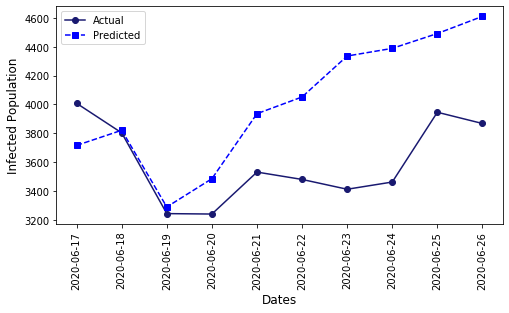

In [257]:
plt.figure(figsize=(8,4))
plt.plot(date, infect, color = 'midnightblue', label = 'Actual', linestyle='-', marker='o')
plt.plot(date, i, color = 'blue', label = 'Predicted', linestyle='--', marker='s')

plt.xticks(rotation=90)
plt.xlabel("Dates", fontsize=12)
plt.ylabel("Infected Population", fontsize=12)

plt.legend(prop={'size':10}, loc='upper left')
plt.show()

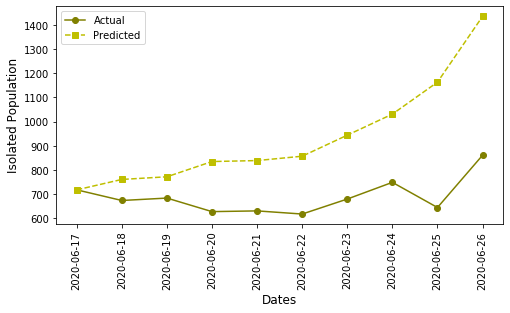

In [258]:
plt.figure(figsize=(8,4))
plt.plot(date, isolate, color = 'olive', label = 'Actual', linestyle='-', marker='o')
plt.plot(date, iso, color = 'y', label = 'Predicted', linestyle='--', marker='s')

plt.xticks(rotation=90)
plt.xlabel("Dates", fontsize=12)
plt.ylabel("Isolated Population", fontsize=12)

plt.legend(prop={'size':10}, loc='upper left')
plt.show()

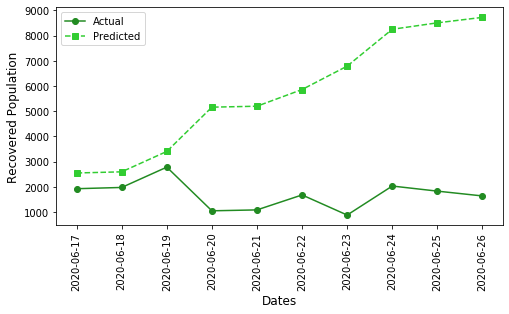

In [237]:
plt.figure(figsize=(8,4))
plt.plot(date, recover, color = 'forestgreen', label = 'Actual', linestyle='-', marker='o')
plt.plot(date, r, color = 'limegreen', label = 'Predicted', linestyle='--', marker='s')

plt.xticks(rotation=90)
plt.xlabel("Dates", fontsize=12)
plt.ylabel("Recovered Population", fontsize=12)

plt.legend(prop={'size':10}, loc='upper left')
plt.show()

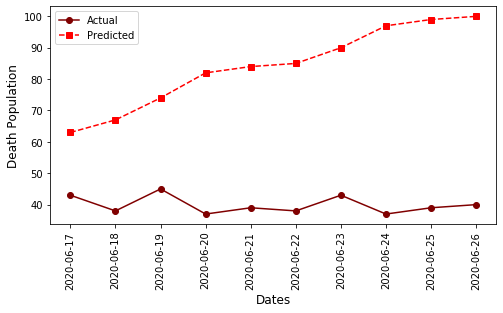

In [238]:
plt.figure(figsize=(8,4))
plt.plot(date, death, color = 'maroon', label = 'Actual', linestyle='-', marker='o')
plt.plot(date, d, color = 'red', label = 'Predicted', linestyle='--', marker='s')

plt.xticks(rotation=90)
plt.xlabel("Dates", fontsize=12)
plt.ylabel("Death Population", fontsize=12)

plt.legend(prop={'size':10}, loc='upper left')
plt.show()